In [17]:
# **Step 2: The Python Script (`train_snake.py`)**

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import elastica as ea
from collections import defaultdict
from typing import Optional
from numpy.typing import NDArray
# from PyElastica.elastica.timestepper.symplectic_steppers import do_step
# from PyElastica.elastica.timestepper import extend_stepper_interface
from elastica.typing import RodType


from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback

import matplotlib.pyplot as plt

import os

from snake_env import FixedWavelengthContinuumSnakeEnv
import config

In [18]:
from visualization import visualization

v1 = visualization()



In [29]:
# Reload config module to get latest changes
import importlib
importlib.reload(config)

config.ENV_CONFIG["_n_elem"] = 10

env = FixedWavelengthContinuumSnakeEnv(
    fixed_wavelength=config.ENV_CONFIG["fixed_wavelength"],
    obs_keys=config.ENV_CONFIG["obs_keys"],
)

# Configure environment parameters
env.period = config.ENV_CONFIG["period"]
env.ratio_time = config.ENV_CONFIG["ratio_time"]
env.rut_ratio = config.ENV_CONFIG["rut_ratio"]
env._n_elem = config.ENV_CONFIG["_n_elem"]

obs, _ = env.reset()

In [30]:
env._n_elem

10

In [8]:
model_path = os.path.join("Training", "Saved_Models", "PPO_Snake_Model")

print(f"\nLoading model from {model_path}...")
if not os.path.exists(model_path + ".zip"):
    print(f"Error: Model file not found at {model_path}.zip")
    
model = PPO.load(model_path, env=env)
print("Model loaded successfully!")



Loading model from Training/Saved_Models/PPO_Snake_Model...
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Model loaded successfully!


In [31]:
import contextlib
import io


# Run a few steps using the trained model
num_steps = 5000  # Change this to run more or fewer steps
print(f"\nRunning {num_steps} steps with trained model...")
print("=" * 70)





# Run evaluation
print(f"\nRunning {num_steps} steps with trained model...")
print("=" * 70)

total_reward = 0.0
episode_count = 0

for i in range(num_steps):
    # Get action from model
    # action, _states = model.predict(obs, deterministic=True)
    
    # Raw torque values (in N⋅m)
    raw_torque = np.array([3.4e-3, 3.3e-3, 4.2e-3, 2.6e-3, 3.6e-3, 3.5e-3], dtype=np.float64)
    # Map torque values to normalized action space [-1, 1] using environment's mapping rule
    action = env._map_torque_to_action(raw_torque).astype(np.float32)
    
    # Step environment (suppress stdout from elastica)
    with contextlib.redirect_stdout(io.StringIO()):
        obs, reward, terminated, truncated, info = env.step(action)
    
    # Accumulate reward
    total_reward += reward
    
    # Print step information
    action_str = np.array2string(action, precision=6, suppress_small=True)
    status_line = (
        f"Step {i+1}/{num_steps} | "
        f"Time: {info['current_time']:.2f}s | "
        f"Forward: {info['forward_speed']:.4f} m/s | "
        f"Lateral: {info['lateral_speed']:.4f} m/s | "
        f"Reward: {reward:.4f} | "
        f"Pos: [{info['position'][0]:.3f}, {info['position'][1]:.3f}, {info['position'][2]:.3f}] | "
        f"Action: {action_str}"
    )
    print(status_line)
    
    # Check if episode ended
    if terminated or truncated:
        episode_count += 1
        print(f"\nEpisode {episode_count} ended at step {i+1}")
        print(f"  Final position: {info['position']}")
        print(f"  Episode reward: {total_reward:.4f}")
        obs, _ = env.reset()
        print("Environment reset for next episode\n")
        total_reward = 0.0

# Print summary
print("\n" + "=" * 70)
print(f"Evaluation complete!")
print(f"Total steps: {num_steps}")
print(f"Episodes completed: {episode_count}")
print(f"Average reward per step: {total_reward/num_steps:.4f}")
print("=" * 70)


Running 5000 steps with trained model...

Running 5000 steps with trained model...
Step 1/5000 | Time: 0.01s | Forward: 0.0004 m/s | Lateral: 0.0000 m/s | Reward: 0.3164 | Pos: [0.000, 0.000, 0.175] | Action: [0.657143 0.671429 0.542857 0.771429 0.628571 0.642857]
Step 2/5000 | Time: 0.02s | Forward: 0.0007 m/s | Lateral: 0.0000 m/s | Reward: 0.3180 | Pos: [0.000, 0.000, 0.175] | Action: [0.657143 0.671429 0.542857 0.771429 0.628571 0.642857]
Step 3/5000 | Time: 0.03s | Forward: 0.0028 m/s | Lateral: 0.0000 m/s | Reward: 0.2688 | Pos: [0.000, 0.000, 0.175] | Action: [0.657143 0.671429 0.542857 0.771429 0.628571 0.642857]
Step 4/5000 | Time: 0.04s | Forward: 0.0067 m/s | Lateral: 0.0000 m/s | Reward: 0.1749 | Pos: [0.000, 0.000, 0.175] | Action: [0.657143 0.671429 0.542857 0.771429 0.628571 0.642857]
Step 5/5000 | Time: 0.05s | Forward: 0.0095 m/s | Lateral: 0.0000 m/s | Reward: 0.0576 | Pos: [0.000, 0.000, 0.175] | Action: [0.657143 0.671429 0.542857 0.771429 0.628571 0.642857]
Step 6

ValueError: x and y can be no greater than 2D, but have shapes (5000,) and (5000, 3, 9)

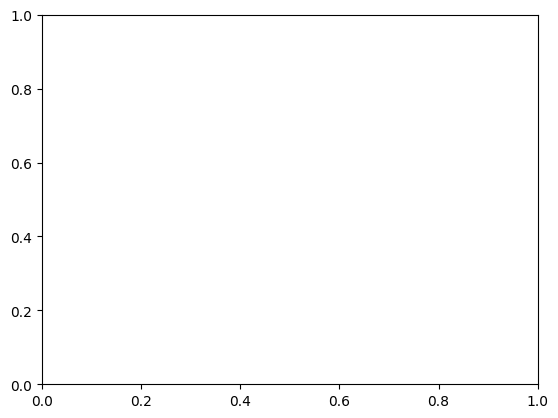

In [ ]:

# Visualize trajectory in 2D (X vs Z)
avg_positions = np.asarray(env.state_dict['avg_position'])
# v1.trajectory_2d(avg_positions[:, 0], avg_positions[:, 2])

# Visualize velocity norm history
avg_velocities = np.asarray(env.state_dict['avg_velocity'])
# v1.velocity_norm_history(env.state_dict['time'], avg_velocities)

# Visualize trajectory in 3D
# v1.trajectory_3d(avg_positions)

# v1.trajectory_2d(avg_positions[:, 0], avg_positions[:, 2])


In [36]:


# Prepare curvature data
# Curvature is stored as a list of arrays with shape (3, n_elem - 1)
if len(env.state_dict['curvature']) > 0:
    n_curvature_elements = env.state_dict['curvature'][0].shape[1]  # n_elem - 1
    # Sample up to 10 elements evenly along the snake
    n_samples = min(10, n_curvature_elements)
    if n_curvature_elements > 1:
        element_indices = np.linspace(0, n_curvature_elements - 1, n_samples, dtype=int)
    else:
        element_indices = [0]
    
    # Compute mean magnitude of curvature at each time step
    curvature_magnitudes_mean = []
    for kappa in env.state_dict['curvature']:
        # kappa has shape (3, n_elem - 1), compute magnitude for each element then take mean
        magnitude = np.mean(np.linalg.norm(kappa, axis=0))
        curvature_magnitudes_mean.append(magnitude)
    
    # Compute curvature magnitude for each sampled element
    curvature_by_element = {idx: [] for idx in element_indices}
    for kappa in env.state_dict['curvature']:
        # Compute magnitude for each element (shape: (n_elem - 1,))
        element_magnitudes = np.linalg.norm(kappa, axis=0)
        for idx in element_indices:
            curvature_by_element[idx].append(element_magnitudes[idx])
else:
    print("No curvature data available")


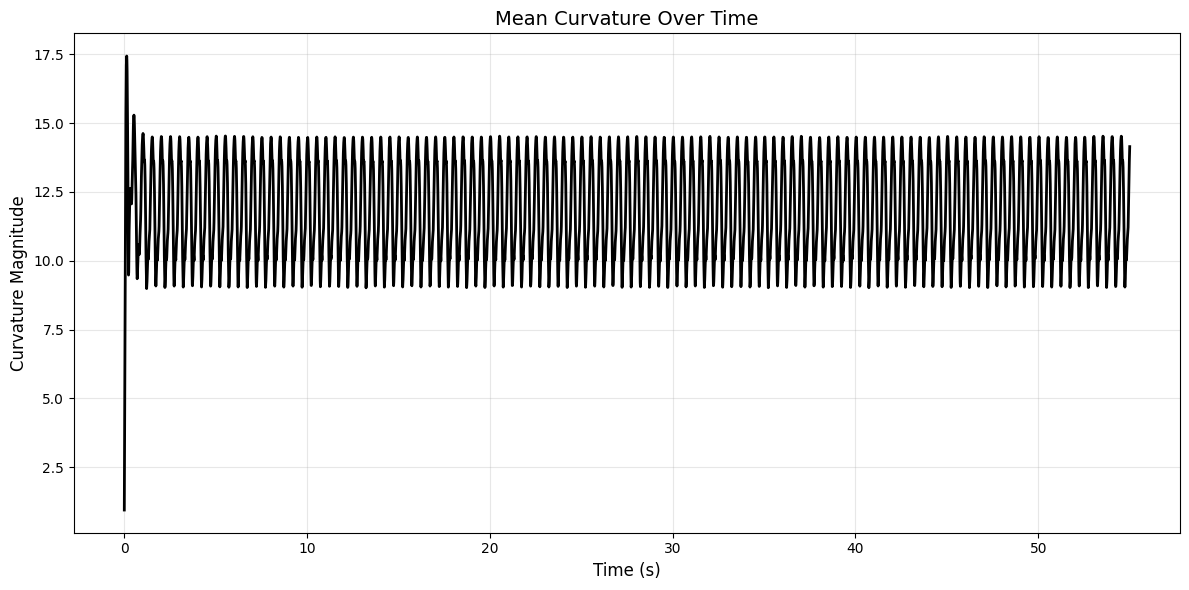

In [37]:
# Plot 1: Mean curvature over time
if len(env.state_dict['curvature']) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(env.state_dict['time'], curvature_magnitudes_mean, 
            color='black', linewidth=2)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Curvature Magnitude', fontsize=12)
    plt.title('Mean Curvature Over Time', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No curvature data available")


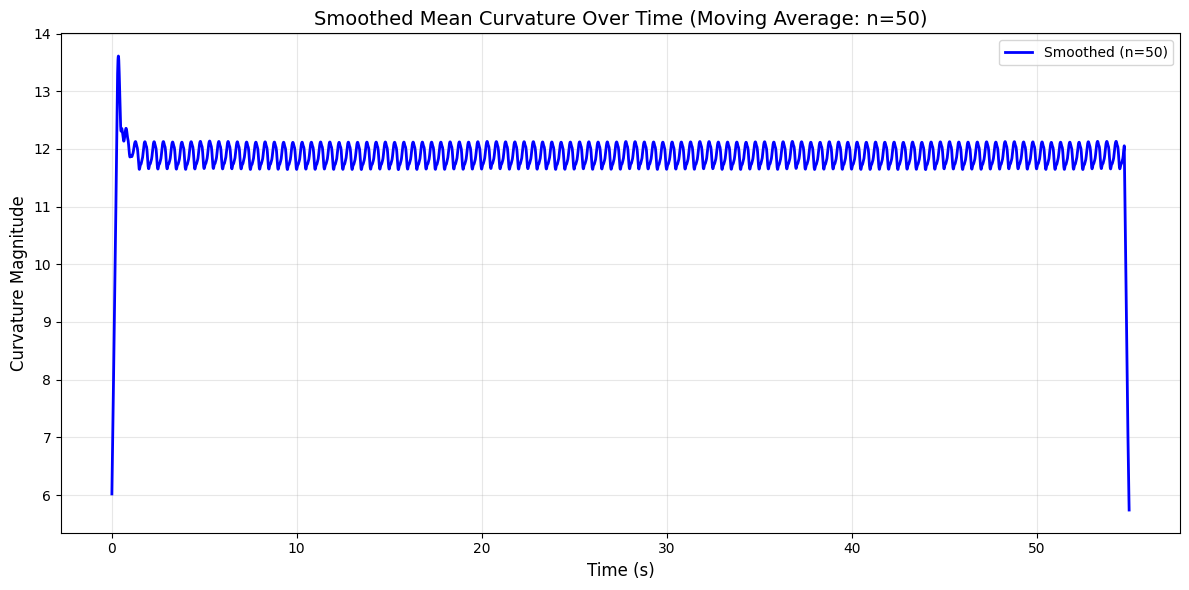

In [39]:
# Plot 3: Smoothed mean curvature over time (using moving average)
# Parameter n: number of data points to average over
n = 50  # Adjust this value to change the smoothing level (larger = smoother)

if len(env.state_dict['curvature']) > 0:
    # Compute smoothed mean curvature using moving average
    curvature_array = np.array(curvature_magnitudes_mean)
    
    # Apply moving average filter
    if len(curvature_array) >= n:
        # Create a uniform window for moving average
        kernel = np.ones(n) / n
        curvature_smoothed = np.convolve(curvature_array, kernel, mode='same')
    else:
        # If data is shorter than n, just use the original data
        curvature_smoothed = curvature_array
    
    # Plot smoothed mean curvature
    plt.figure(figsize=(12, 6))
    plt.plot(env.state_dict['time'], curvature_smoothed, 
            color='blue', linewidth=2, label=f'Smoothed (n={n})')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Curvature Magnitude', fontsize=12)
    plt.title(f'Smoothed Mean Curvature Over Time (Moving Average: n={n})', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No curvature data available")


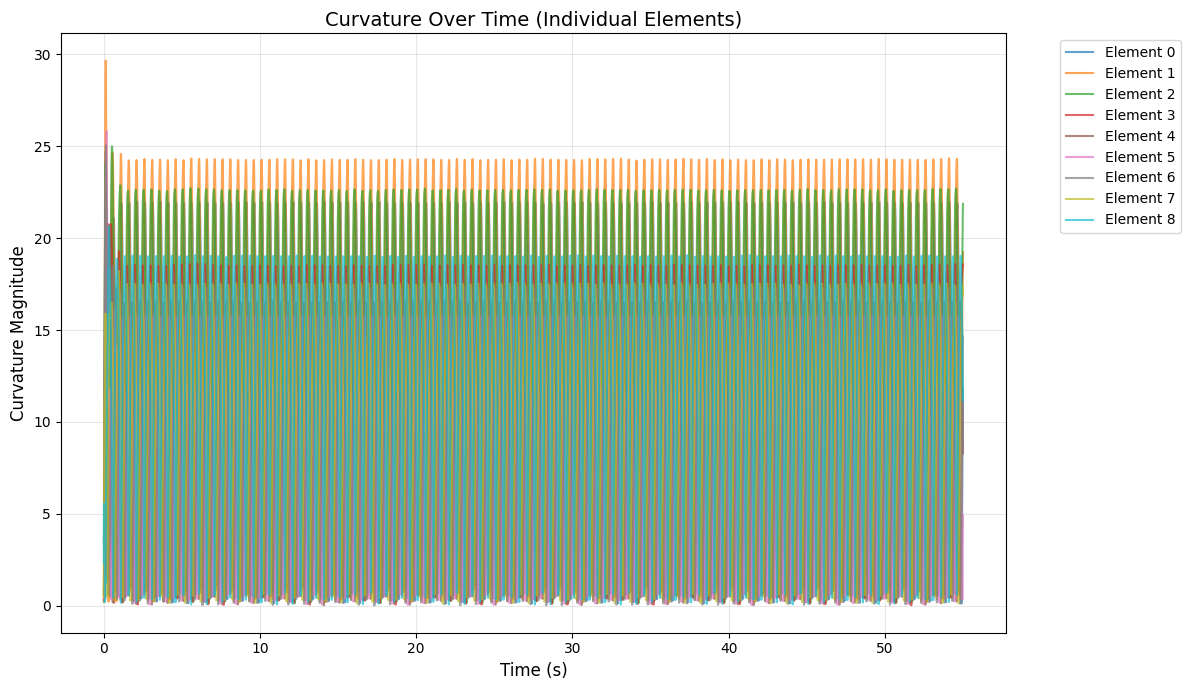

In [38]:
# Plot 2: Individual elements (up to 10) curvature over time
if len(env.state_dict['curvature']) > 0:
    plt.figure(figsize=(12, 7))
    
    # Plot individual elements
    colors = plt.cm.tab10(np.linspace(0, 1, len(element_indices)))
    for i, idx in enumerate(element_indices):
        plt.plot(env.state_dict['time'], curvature_by_element[idx], 
                label=f'Element {idx}', alpha=0.7, color=colors[i], linewidth=1.5)
    
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Curvature Magnitude', fontsize=12)
    plt.title('Curvature Over Time (Individual Elements)', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No curvature data available")


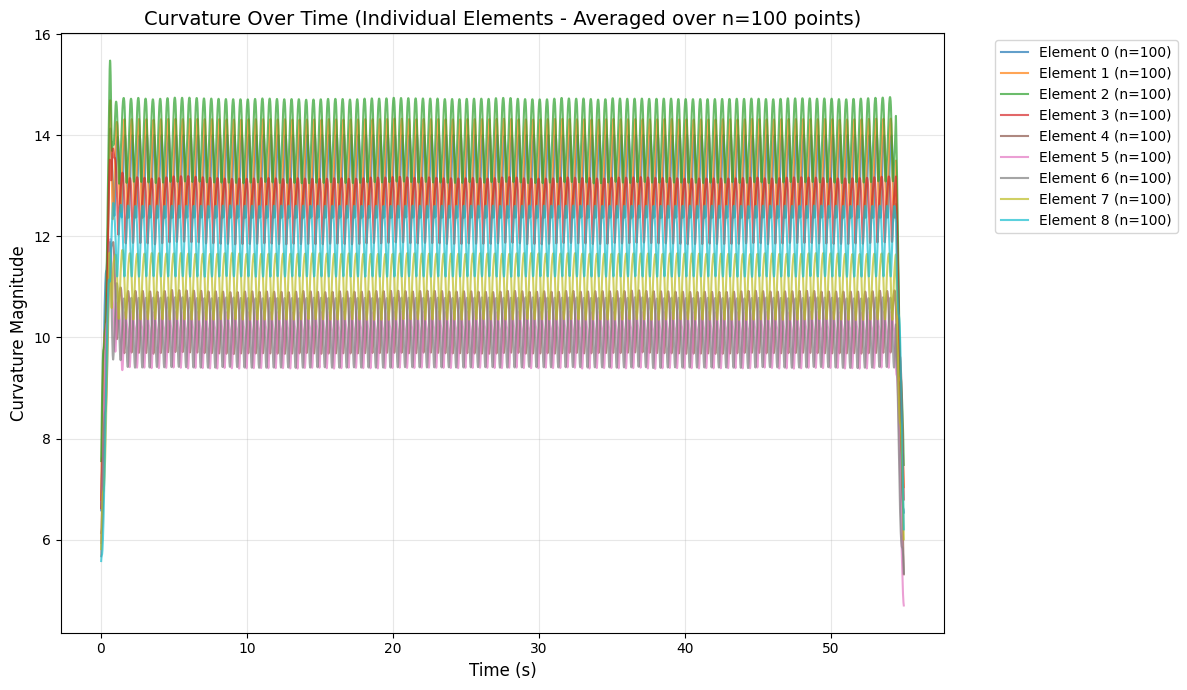

In [46]:
# Plot 4: Individual elements (up to 10) curvature over time - averaged over n data points
# Parameter n: number of data points to average over
n = 100  # Adjust this value to change the smoothing level (larger = smoother)

if len(env.state_dict['curvature']) > 0:
    plt.figure(figsize=(12, 7))
    
    # Plot smoothed individual elements
    colors = plt.cm.tab10(np.linspace(0, 1, len(element_indices)))
    for i, idx in enumerate(element_indices):
        # Get curvature data for this element
        curvature_array = np.array(curvature_by_element[idx])
        
        # Apply moving average filter
        if len(curvature_array) >= n:
            # Create a uniform window for moving average
            kernel = np.ones(n) / n
            curvature_smoothed = np.convolve(curvature_array, kernel, mode='same')
        else:
            # If data is shorter than n, just use the original data
            curvature_smoothed = curvature_array
        
        plt.plot(env.state_dict['time'], curvature_smoothed, 
                label=f'Element {idx} (n={n})', alpha=0.7, color=colors[i], linewidth=1.5)
    
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Curvature Magnitude', fontsize=12)
    plt.title(f'Curvature Over Time (Individual Elements - Averaged over n={n} points)', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No curvature data available")



OSCILLATION AMPLITUDE ANALYSIS FOR EACH ELEMENT
Element    Mean            Peak-to-Peak    RMS Amplitude   Max             Min            
--------------------------------------------------------------------------------
0          13.272800       24.550987       6.474567        24.682508       0.131521       
1          13.380169       29.446740       8.252104        29.661009       0.214269       
2          13.963012       24.857922       6.954755        24.998129       0.140207       
3          12.657312       20.737238       5.245174        20.763638       0.026400       
4          10.408682       20.570593       4.924492        20.597924       0.027331       
5          10.071327       25.772634       4.441415        25.824719       0.052085       
6          10.180267       25.033193       5.698459        25.049192       0.015999       
7          11.124763       18.102613       5.347088        18.220916       0.118303       
8          12.012275       20.581274       5.672061 

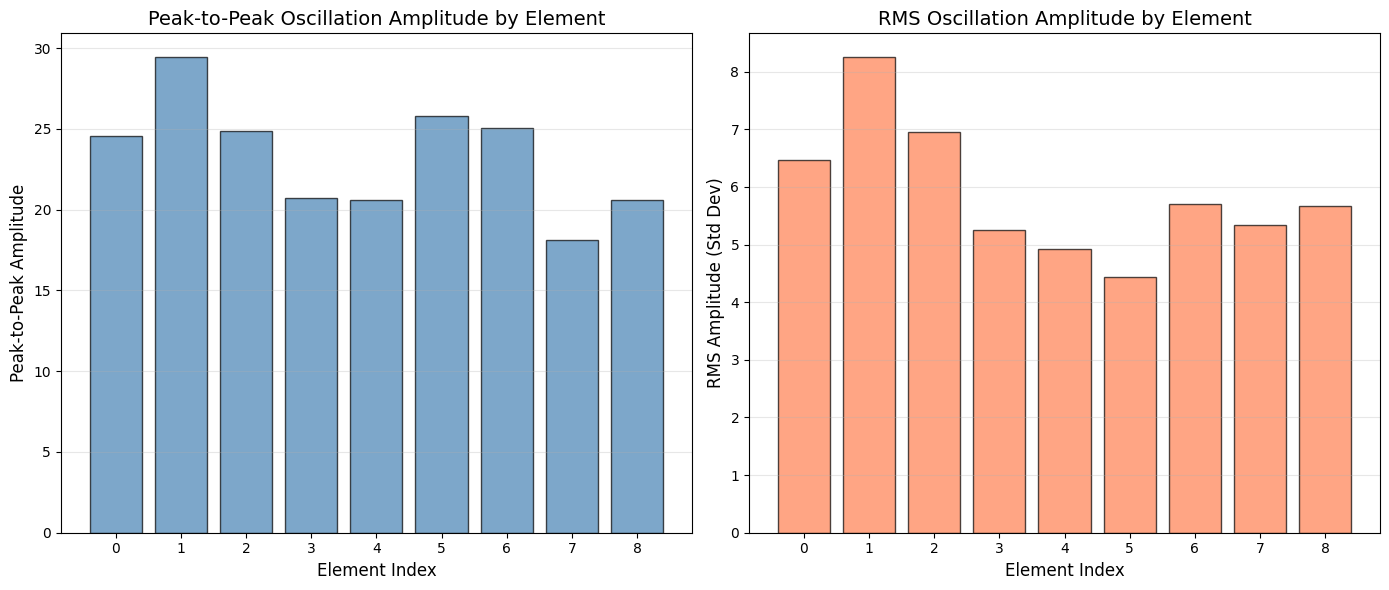

In [44]:
# Calculate oscillation amplitude for each element
if len(env.state_dict['curvature']) > 0:
    print("=" * 80)
    print("OSCILLATION AMPLITUDE ANALYSIS FOR EACH ELEMENT")
    print("=" * 80)
    print(f"{'Element':<10} {'Mean':<15} {'Peak-to-Peak':<15} {'RMS Amplitude':<15} {'Max':<15} {'Min':<15}")
    print("-" * 80)
    
    amplitudes_peak_to_peak = {}
    amplitudes_rms = {}
    means = {}
    
    for idx in element_indices:
        curvature_array = np.array(curvature_by_element[idx])
        
        # Calculate statistics
        mean_val = np.mean(curvature_array)
        max_val = np.max(curvature_array)
        min_val = np.min(curvature_array)
        peak_to_peak = max_val - min_val
        rms_amplitude = np.std(curvature_array)  # RMS amplitude (standard deviation)
        
        # Store for plotting
        amplitudes_peak_to_peak[idx] = peak_to_peak
        amplitudes_rms[idx] = rms_amplitude
        means[idx] = mean_val
        
        # Print results
        print(f"{idx:<10} {mean_val:<15.6f} {peak_to_peak:<15.6f} {rms_amplitude:<15.6f} {max_val:<15.6f} {min_val:<15.6f}")
    
    print("=" * 80)
    print("\nNote: RMS Amplitude = standard deviation (measure of oscillation around mean)")
    print("      Peak-to-Peak = maximum - minimum (full range of oscillation)")
    print("=" * 80)
    
    # Visualize amplitudes
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: Peak-to-Peak Amplitude
    elements = list(amplitudes_peak_to_peak.keys())
    peak_to_peak_vals = [amplitudes_peak_to_peak[idx] for idx in elements]
    ax1.bar(elements, peak_to_peak_vals, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.set_xlabel('Element Index', fontsize=12)
    ax1.set_ylabel('Peak-to-Peak Amplitude', fontsize=12)
    ax1.set_title('Peak-to-Peak Oscillation Amplitude by Element', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_xticks(elements)
    
    # Plot 2: RMS Amplitude
    rms_vals = [amplitudes_rms[idx] for idx in elements]
    ax2.bar(elements, rms_vals, alpha=0.7, color='coral', edgecolor='black')
    ax2.set_xlabel('Element Index', fontsize=12)
    ax2.set_ylabel('RMS Amplitude (Std Dev)', fontsize=12)
    ax2.set_title('RMS Oscillation Amplitude by Element', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticks(elements)
    
    plt.tight_layout()
    plt.show()
    
    # Store results in a dictionary for further analysis
    amplitude_results = {
        'element_indices': elements,
        'peak_to_peak': amplitudes_peak_to_peak,
        'rms_amplitude': amplitudes_rms,
        'means': means
    }
    
else:
    print("No curvature data available")



In [ ]:

# plt.plot(env.state_dict['time'], env.state_dict['reward'])


# Visualize current snake shape
# v1.current_shape_3d(env.shearable_rod)

# Plot video from callback data
# v1.plot_video(env.callback_data)

# v1.plot_video_auto_limits(
#     env.callback_data,
#     "video_auto_limits.mp4",
#     1500,
# )

